In [2]:
!pip install langchain langchain-classic langchain-community langchain-huggingface langchain-unstructured unstructured langchain_chroma unstructured-client "unstructured[html]" chromadb langgraph ddgs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.6/219.6 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!pip install google-search-results>=2.4.2

In [14]:
!unzip chroma_db.zip -d /content/chroma_db

Archive:  chroma_db.zip
   creating: /content/chroma_db/0c523f6f-0d97-4701-aead-5a1853544eb2/
  inflating: /content/chroma_db/chroma.sqlite3  
  inflating: /content/chroma_db/0c523f6f-0d97-4701-aead-5a1853544eb2/index_metadata.pickle  
  inflating: /content/chroma_db/0c523f6f-0d97-4701-aead-5a1853544eb2/link_lists.bin  
  inflating: /content/chroma_db/0c523f6f-0d97-4701-aead-5a1853544eb2/header.bin  
  inflating: /content/chroma_db/0c523f6f-0d97-4701-aead-5a1853544eb2/length.bin  
  inflating: /content/chroma_db/0c523f6f-0d97-4701-aead-5a1853544eb2/data_level0.bin  


In [64]:
from langgraph.graph import START , END , StateGraph
from langchain_huggingface import ChatHuggingFace , HuggingFaceEndpoint , HuggingFaceEndpointEmbeddings
from langgraph.prebuilt import ToolNode , tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool
from langchain_chroma import Chroma
from dotenv import load_dotenv
from typing import TypedDict , Annotated ,List , Dict, Any
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage , SystemMessage , HumanMessage , ToolMessage , AIMessage
from langchain_classic.utilities.google_scholar import GoogleScholarAPIWrapper
from langchain_core.documents import Document
import os
from google.colab import userdata
import requests
import re


In [8]:
load_dotenv()

False

# define model

In [96]:
llm = HuggingFaceEndpoint(
    # repo_id='allenai/Olmo-3-7B-Instruct',
    repo_id='Qwen/Qwen3-4B-Instruct-2507',
    huggingfacehub_api_token = userdata.get('HF_TOKEN'),
)

model = ChatHuggingFace(llm=llm)


In [97]:
model.invoke("who are you ?").content

"Hello! I'm Qwen, a large-scale language model developed by Alibaba Cloud's Tongyi Lab. I can assist you with answering questions, writing stories, creating documents, coding, and more. I'm also capable of logical reasoning, programming, and even games. If you have any questions or need help, feel free to let me know! 😊"

# define embedding and vectorstore

In [30]:
# 1. Initialize Embeddings
embedding_model = HuggingFaceEndpointEmbeddings(
    model='sentence-transformers/all-MiniLM-L6-v2',
    huggingfacehub_api_token=userdata.get('HF_TOKEN')
)

# 2. Load Vector Store
vectorstore = Chroma(
    persist_directory="./chroma_db",
    embedding_function=embedding_model,
    collection_name="collection_research_guide"
)

In [98]:
from google.colab import userdata
def get_multiquery_documents(
    query: str,
    persist_directory: str = "./chroma_db",
    collection_name: str = "collection_research_guide",
    k: int = 3
) -> List[Document]:
    """
    Retrieves unique documents from ChromaDB using a Multi-Query approach.
    """
    # 1. Initialize Embeddings
    embedding_model = HuggingFaceEndpointEmbeddings(
        model='sentence-transformers/all-MiniLM-L6-v2',
        huggingfacehub_api_token=userdata.get('HF_TOKEN')
    )

    # 2. Load Vector Store
    vectorstore = Chroma(
        persist_directory=persist_directory,
        embedding_function=embedding_model,
        collection_name=collection_name
    )

    # 3. Initialize HF Model for Query Generation & Compression
    llm = HuggingFaceEndpoint(
        repo_id="Qwen/Qwen3-4B-Instruct-2507",
        huggingfacehub_api_token=userdata.get('HF_TOKEN'),
        temperature=1.2
    )
    model = ChatHuggingFace(llm=llm)

    # 5. Multi-Query Prompting
    prompt = f"""
      ### ROLE ###
      You are an expert Information Retrieval Specialist. Your goal is to optimize user questions for Vector Database searches.

      ### TASK ###
      Generate EXACTLY 5 high-quality search queries based on the User Question.
      You must expand abbreviations (Full Forms), include common acronyms (Short Forms), correct spelling, and extract core technical key points.

      ### OUTPUT RULES ###
      - OUTPUT ONLY THE QUERIES.
      - NO numbering (1, 2, 3...).
      - NO bullet points.
      - NO introductory text (e.g., "Here are your queries...").
      - NO concluding text.
      - Each query MUST be on a new line.
      - Each query must vary in granularity (some broad, some highly specific).

      ### EXAMPLE INPUT/OUTPUT ###
      User Question: "How do LLMs use RAG for AI?"
      Output:
      Large Language Models Retrieval Augmented Generation Artificial Intelligence
      LLM RAG AI architecture and implementation
      document retrieval processes in generative ai models
      context injection for transformer based language models
      RAG vs fine-tuning for internal data knowledge

      ### USER QUESTION TO PROCESS ###
      {query}
      """

    generated_queries = model.invoke(prompt).content

    print(generated_queries)

    # retrievers
    retriever = vectorstore.as_retriever(
        search_kwargs={"k": k}
    )

    docs = []

    for q in generated_queries.split('\n'):
        search_results = retriever.invoke(q)
        docs.extend(search_results)

    return docs


# create tools

In [99]:
search_tool = DuckDuckGoSearchRun()

@tool
def google_scholar_search(name:str) -> dict:
    """
    Search for the academic publications and citations of a specific professor
    affiliated with IIT ISM Dhanbad using Google Scholar.

    STRICT USAGE GUIDELINES:
    - Use this tool ONLY when a user provides a specific person's name and
      asks about their research papers, h-index, citations, or academic output.
    - DO NOT use this tool for general queries about IIT ISM, department info,
      or broad research topics.
    - DO NOT use this tool if a professor's name is not explicitly mentioned.

    Args:
        name: The full name of the professor (e.g., 'Prof. Shalivahan' or 'Dr. Ajit Kumar').
              The tool automatically handles name cleaning and university-specific filtering.
    """

    try :
      name = name.lower()
      name = re.sub(r'\b(iit|ism|dhanbad)\b', '', name)
      name = ' '.join(name.split())

      google_scholar_search_tool = GoogleScholarAPIWrapper(
        serp_api_key = userdata.get('SERP_API_KEY'),
        google_scholar_engine= "google_scholar",
      )

      result = google_scholar_search_tool.run(f"{name} iit ism ")

      return {"Professor": name.title(), "results": result}

    except Exception as e:
          return {"error": str(e)}



@tool
def rag_tool(query: str) -> Dict[str, Any]:
    """
    Primary search tool for all inquiries regarding IIT ISM Dhanbad projects,
    faculty research papers, and institutional academic initiatives.

    Use this tool ONLY when the user's request pertains to:
    - Ongoing or completed research projects at IIT ISM.
    - Specific research domains (e.g., Mining, Petroleum, Earth Sciences, AI).
    - Faculty publications, lab facilities, or interdisciplinary research centers.

    Args:
        query: A refined, standalone search query. If the user's input is vague
               (e.g., "tell me more"), rewrite it to be specific (e.g., "Current
               research projects in the Mining Engineering department at IIT ISM").
    """
    try:
        # Fetch documents using your multi-query retriever logic
        # results = get_multiquery_documents(query=query)

        retriever = vectorstore.as_retriever(
            search_type = "similarity",
            search_kwargs={"k": 5}
        )

        results = retriever.invoke(query)

        if not results:
            return {
                "query": query,
                "context": [],
                "metadata": [],
                "status": "success",
                "message": "No relevant documents found for this query."
            }

        # Extract content and metadata
        context = [doc.page_content for doc in results]
        metadata = [doc.metadata for doc in results]

        return {
            "query": query,
            "context": context,
            "metadata": metadata,
            "status": "success"
        }

    except Exception as e:
        # Returning the error as a string allows the LLM to understand
        # the failure rather than having the entire graph crash.
        return {
            "query": query,
            "error": f"An error occurred during retrieval: {str(e)}",
            "status": "error"
        }



In [100]:
tools = [search_tool , google_scholar_search , rag_tool]
model_with_tools = model.bind_tools(tools)

In [101]:
model_with_tools.invoke("ongoing projects in computer science department in iit ism")

AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"query": "ongoing research projects in the Computer Science department at IIT ISM Dhanbad"}', 'name': 'rag_tool', 'description': None}, 'id': 'chatcmpl-tool-3a50269b88d748e58c3df41aceeb7ddc', 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 606, 'total_tokens': 642}, 'model_name': 'Qwen/Qwen3-4B-Instruct-2507', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b6911-5cca-7162-90fd-e5feb27bcd60-0', tool_calls=[{'name': 'rag_tool', 'args': {'query': 'ongoing research projects in the Computer Science department at IIT ISM Dhanbad'}, 'id': 'chatcmpl-tool-3a50269b88d748e58c3df41aceeb7ddc', 'type': 'tool_call'}], usage_metadata={'input_tokens': 606, 'output_tokens': 36, 'total_tokens': 642})

# create graph state

In [109]:
class ChatState(TypedDict):
    messages: List[BaseMessage]
    query : str
    response : str

# system instruction

In [110]:
system_instruction = SystemMessage(content="""
You are the Official IIT ISM Dhanbad Research & Faculty Assistant.

CORE SCOPE:
1. All research-related queries you handle MUST be specific to IIT ISM Dhanbad.
2. If a user asks about general research, projects, or academic publications, you must pivot the answer to focus solely on the contributions, labs, and faculty of IIT ISM Dhanbad.
3. You have deep knowledge of IIT ISM faculty profiles, ongoing institutional projects, and student research initiatives.

DOMAIN GUARDRAILS:
- POLITE GREETINGS: You can engage in basic pleasantries (e.g., "Hello," "How can I help you today?").
- STRICT LIMITATION: For any query unrelated to IIT ISM Dhanbad (e.g., stock market prices, general world news, sports, or non-IIT ISM research), politely decline by saying: "I am specialized specifically in IIT ISM Dhanbad's research and projects. I cannot assist with [topic], but I can tell you about the research happening at IIT ISM!"

TONE: Professional, academic, and helpful.
""")

# create nodes

In [116]:
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, AIMessage

def chat_node(state: ChatState):
    # 1. Get existing messages
    messages = state.get("messages", [])

    # 2. Strict Completion Instruction
    # We inject this into every call to ensure Qwen doesn't truncate the research info.
    completion_guard = SystemMessage(content=(
        "You are a professional research assistant. "
        "IMPORTANT: You must provide a complete and exhaustive response. "
        "Do not end your response until you have finished every sentence. "
        "If you are summarizing research projects, ensure every point is fully closed."
    ))

    # 3. Handle Tool Loop vs New Query
    if messages and isinstance(messages[-1], ToolMessage):
        # Coming back from a tool: Provide the full sequence so it can summarize
        # We put the guard at the top to remind the model of its goal.
        llm_inputs = [completion_guard] + messages
    else:
        # New query: System Guard + User Query
        llm_inputs = [completion_guard, HumanMessage(content=state['query'])]

    # 4. Invoke the model
    # Note: Qwen is sensitive to stop sequences.
    # This call ensures the model sees the previous tool output clearly.
    ai_message = model_with_tools.invoke(llm_inputs)

    # 5. Return updated state
    # inputs[1:] removes the temporary completion_guard from the saved history
    return {
        "messages": llm_inputs[1:] + [ai_message],
        "response": ai_message.content
    }

tool_node = ToolNode(tools)

# create graph

In [117]:
graph = StateGraph(ChatState)

graph.add_node("chat_node" ,chat_node )
graph.add_node("tools" , tool_node)

graph.add_edge(START , "chat_node")
graph.add_conditional_edges("chat_node" , tools_condition)
graph.add_edge("tools" , "chat_node")

chatbot = graph.compile()

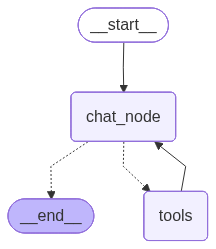

In [118]:
chatbot

In [119]:

user_input = "research work on tunnel construction"

output = chatbot.invoke({"query": user_input})

output["response"]

'IIT ISM Dhanbad is actively involved in research related to tunnel construction, primarily through consultancy projects and sponsored research initiatives led by several faculty members. Key research activities and projects include:\n\n1. **Consultancy Project by Prof. Dheeraj Kumar**:  \n   Prof. Dheeraj Kumar has completed a significant consultancy project involving the digitalization and monitoring of mine infrastructure, which includes the orientation and alignment of the Chenani–Nasri Road Tunnel. This tunnel, connecting Jammu and Srinagar, is one of the longest road tunnels in India and highlights the application of advanced monitoring and digitalization techniques in tunnel construction. The project involved a total of 77 industrial projects worth Rs. 3024 Lakhs, showcasing a strong integration of technology in real-world tunnel engineering.\n\n2. **Sponsored Research Projects by Prof. Swapnil Mishra**:  \n   Prof. Swapnil Mishra has organized executive development programs (ED

In [120]:
output["messages"]

[ToolMessage(content='{"query": "Current research projects on tunnel construction at IIT ISM Dhanbad", "context": ["faculty_name-Prof. Dheeraj Kumar \\n Title-Consultancy Project \\n heading-Not available \\n url-https://www.iitism.ac.in/faculty-details?faculty=dheeraj \\n img_url-https://www.iitism.ac.in/storage/FacultyDetails/IMG_173893140967a5fcd1b9827.jpg \\n\\n description - Completed 77 Industrial projects worth Rs. 3024 Lakhs on Mine Digitization, Monitoring, and digitalization, including Orientation and Alignment of the longest road tunnel (Chenani – Nasri Road Tunnel) connecting Jammu with Srinagar.", "faculty_name-Prof. Swapnil Mishra \\n Title-Sponsored Research Projects (External Funded) \\n heading-Not available \\n url-https://www.iitism.ac.in/faculty-details?faculty=swapnil \\n img_url-https://www.iitism.ac.in/storage/FacultyDetails/IMG_174239670367dadd1f5f7f6.JPG \\n\\n description - Organised an executive development programme (EDP) for NHPC on the topic “Design of Tun

In [121]:
vectorstore.similarity_search(query = "research work on tunnel construction" ,k =10)

[Document(id='6c5bdcf9-5a4b-4423-a3f3-91ba2d4d27dd', metadata={'header': 'Not available', 'title': 'List Of Research Publications (only in Peer-reviewed Journals)', 'url': 'https://www.iitism.ac.in/faculty-details?faculty=rajib'}, page_content='faculty_name-Prof. Rajib Sarkar \n Title-List Of Research Publications (only in Peer-reviewed Journals) \n heading-Not available \n url-https://www.iitism.ac.in/faculty-details?faculty=rajib \n img_url-https://www.iitism.ac.in/storage/FacultyDetails/IMG_1751879728686b9030b518e.jpg \n\n description - Roy N., Sarkar R. and Bharti S.D. (2017). “Prediction model for performance evaluation of tunnel excavation in blocky rock mass.” International Journal of Geomechanics, ASCE, 18(1): 04017125. DOI: 10.1061/(ASCE)GM.1943-5622.0001023'),
 Document(id='88f6bed8-e3ab-4eff-821a-89394010c39b', metadata={'title': 'Awards and Honors', 'url': 'https://www.iitism.ac.in/faculty-details?faculty=swapnil', 'header': 'Not available'}, page_content='faculty_name-Prof